In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/coursework/

/content/drive/MyDrive/coursework


In [399]:
from tqdm.notebook import tqdm
tqdm.pandas()

import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
%matplotlib inline
sns.set(color_codes=True)
import os
from sklearn.model_selection import GridSearchCV 
from datetime import datetime
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import StandardScaler

from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Boosting Algorithms :
from xgboost  import XGBClassifier
# from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix, normalized_mutual_info_score
from sklearn.linear_model import SGDClassifier


In [400]:
data = pd.read_csv('DiabetesClassificationDataset2022.csv')

In [401]:
pd.set_option("display.max_columns", None)

In [402]:
# Keeping a separate mapping data handy so that we can refer when needed(which encounter was associated with which hospital)
encounter_id_to_hospital_id_df = data[['encounter_id','hospital_id']]

In [403]:
cols_with_null_values = data.isna().sum()

In [404]:
cols_with_null_values[cols_with_null_values>0]

gender                  30
ethnicity              961
age                   2842
height                1181
weight                2073
                     ...  
creatinine_apache    14584
bilirubin_apache     50050
h1_spo2_max           3804
paco2_apache         60619
map_apache             228
Length: 73, dtype: int64

## Checking Data Imbalance

0    51007
1    28152
Name: diabetes_mellitus, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


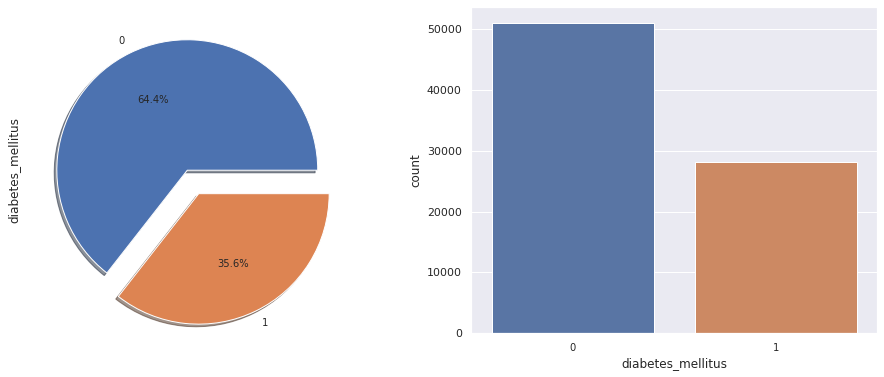

In [405]:
print(data['diabetes_mellitus'].value_counts())
f,ax=plt.subplots(1,2,figsize=(16,6))
labels = ['0', '1']
data['diabetes_mellitus'].value_counts().plot.pie(explode=[0,0.2],autopct='%1.1f%%',ax=ax[0],shadow=True,labels=labels,fontsize=10)
sns.countplot('diabetes_mellitus',data=data, ax=ax[1])
ax[1].set_xticklabels(['0', '1'], fontsize=10)
plt.show()

## Dropping columns with constant data

In [406]:
data.drop(data.columns[data.nunique() <= 1],axis=1,inplace=True)

## Dropping columns with >=80% values as 0 and columns consisting of >=60% NaN values, since these columns would not contribute to the learning of ML models.


In [407]:
def del_zero_and_nan(data):
    percent_missing= (data==0).sum()* 100 / len(data)
    missing_value_df = pd.DataFrame({'column_name': data.columns,
                                     'percent_missing': percent_missing})
    missing_value_df.sort_values('percent_missing', inplace=True,ascending=False)
    all_values_missing= missing_value_df[missing_value_df['percent_missing']>=80]

    all_null_cols1=[]
    for i in all_values_missing['column_name']:
        all_null_cols1.append(i)
    data.drop(all_null_cols1,axis=1,inplace=True)
    print(all_null_cols1)

    percent_missing= data.isnull().sum() * 100 / len(data)
    missing_value_df = pd.DataFrame({'column_name': data.columns,
                                     'percent_missing': percent_missing})
    missing_value_df.sort_values('percent_missing', inplace=True,ascending=False)
    all_values_missing= missing_value_df[missing_value_df['percent_missing']>=60]


    all_null_cols1=[]
    for i in all_values_missing['column_name']:
        all_null_cols1.append(i)
    data.drop(all_null_cols1,axis=1,inplace=True)
    print(all_null_cols1)
    return data

In [408]:
data= del_zero_and_nan(data)

['aids', 'lymphoma', 'leukemia', 'hepatic_failure', 'cirrhosis', 'solid_tumor_with_metastasis', 'immunosuppression', 'intubated_apache', 'elective_surgery']
['h1_bilirubin_max', 'h1_bilirubin_min', 'h1_albumin_min', 'h1_albumin_max', 'h1_lactate_min', 'h1_lactate_max', 'h1_pao2fio2ratio_min', 'h1_pao2fio2ratio_max', 'h1_arterial_ph_min', 'h1_arterial_ph_max', 'h1_arterial_pco2_max', 'h1_arterial_pco2_min', 'h1_arterial_po2_max', 'h1_arterial_po2_min', 'h1_hco3_min', 'h1_hco3_max', 'h1_calcium_max', 'h1_calcium_min', 'h1_bun_max', 'h1_bun_min', 'h1_creatinine_max', 'h1_creatinine_min', 'h1_hematocrit_max', 'h1_hematocrit_min', 'h1_sodium_min', 'h1_sodium_max', 'paco2_apache', 'd1_lactate_min', 'd1_lactate_max', 'd1_pao2fio2ratio_min', 'd1_pao2fio2ratio_max', 'd1_arterial_po2_min', 'd1_arterial_po2_max', 'bilirubin_apache', 'h1_inr_min', 'h1_inr_max', 'd1_inr_min', 'd1_inr_max']


## Dropping duplicate rows if any

In [409]:
data.drop_duplicates(keep = 'first', inplace = True)

## Filling height and weight NaN's with median values

In [410]:
cols = ["height", "weight"]
median = data.filter(cols).median()


In [411]:
median #median height and weight

height    170.0
weight     81.6
dtype: float64

In [412]:
data[cols]=data[cols].fillna(median.iloc[0])

## Calculating BMI again and filling NaN's in BMI column

In [413]:
def bmi_calc(df):
  height_in_m = df['height']/100
  weight = df['weight']
  bmi = weight/(height_in_m**2)
  return bmi 
data['bmi'] = data.progress_apply(bmi_calc,axis=1)

  0%|          | 0/79156 [00:00<?, ?it/s]

In [414]:
data.head()

,encounter_id,hospital_id,gender,ethnicity,age,height,weight,bmi,icu_type,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_glucose_max,h1_glucose_min,wbc_apache,d1_heartrate_max,heart_rate_apache,gcs_motor_apache,gcs_eyes_apache,creatinine_apache,h1_spo2_max,map_apache,ventilated_apache,diabetes_mellitus
0,214826,118,M,Caucasian,68.0,180.3,73.9,22.732803,CTICU,39.5,37.5,2.3,2.3,0.4,0.4,31.0,30.0,109.0,19.0,15.0,233.0,233.0,4.0,3.4,136.0,134.0,14.1,14.1,NaN,NaN,14.1,119.0,118.0,6.0,3.0,2.51,100.0,40.0,0,1
1,276985,118,F,Caucasian,25.0,172.7,95.3,31.952749,Med-Surg ICU,36.7,36.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.0,102.0,6.0,3.0,NaN,98.0,68.0,0,0
2,262220,118,F,Caucasian,81.0,165.1,61.7,22.635548,CTICU,35.6,34.8,NaN,NaN,NaN,NaN,NaN,NaN,88.0,NaN,NaN,198.0,43.0,5.0,3.5,NaN,NaN,9.0,8.0,NaN,NaN,8.0,116.0,114.0,6.0,4.0,NaN,100.0,60.0,1,0
3,201746,33,M,Caucasian,19.0,188.0,170.0,48.098687,Med-Surg ICU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.0,60.0,NaN,NaN,NaN,100.0,103.0,0,0
4,246060,81,F,Caucasian,77.0,160.0,70.2,27.421875,Med-Surg ICU,36.3,36.3,1.6,1.6,0.5,0.5,11.0,9.0,128.0,27.0,26.0,557.0,487.0,4.2,3.8,145.0,145.0,23.3,12.7,145.0,143.0,12.7,118.0,120.0,3.0,1.0,0.56,95.0,46.0,1,1


In [415]:
#FIND OUT CATEGORICAL AND NUMERICAL FEATURES
def get_categorical_features(data):
    cat_feat = data.select_dtypes(include=['O']).columns.values
    return cat_feat

def get_numerical_features(data):
    numerical_features = data.select_dtypes(include=[np.number]).columns.values
    return numerical_features
cat_feat = get_categorical_features(data)
num_feat = get_numerical_features(data)

In [416]:
cat_feat

array(['gender', 'ethnicity', 'icu_type'], dtype=object)

In [417]:
num_feat

array(['encounter_id', 'hospital_id', 'age', 'height', 'weight', 'bmi',
       'h1_temp_max', 'h1_temp_min', 'd1_albumin_max', 'd1_albumin_min',
       'd1_bilirubin_max', 'd1_bilirubin_min', 'd1_bun_max', 'd1_bun_min',
       'd1_glucose_min', 'd1_hco3_max', 'd1_hco3_min', 'd1_platelets_max',
       'd1_platelets_min', 'd1_potassium_max', 'd1_potassium_min',
       'd1_sodium_max', 'd1_sodium_min', 'd1_wbc_max', 'd1_wbc_min',
       'h1_glucose_max', 'h1_glucose_min', 'wbc_apache',
       'd1_heartrate_max', 'heart_rate_apache', 'gcs_motor_apache',
       'gcs_eyes_apache', 'creatinine_apache', 'h1_spo2_max',
       'map_apache', 'ventilated_apache', 'diabetes_mellitus'],
      dtype=object)

## Checking Correlation 

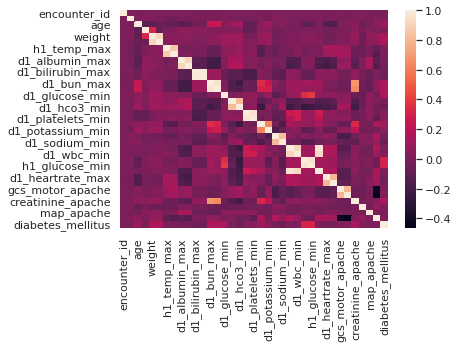

In [418]:
%matplotlib inline
sns.heatmap(data[num_feat].corr(method ='pearson'))
plt.show()

- Correlation matrix will be mirror image about the diagonal and all the diagonal elements will be 1. So, It does not matter that we select the upper triangular or lower triangular part of the correlation matrix but we should not include the diagonal elements. So we are selecting the upper traingular.

In [419]:
cor_matrix = data[num_feat].corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))

- So we are selecting the columns which are having absolute correlation greater than 0.95 and making a list of those columns named 'to_drop'.

In [420]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print(to_drop)

['d1_bilirubin_min', 'd1_bun_min', 'd1_platelets_min', 'h1_glucose_min', 'wbc_apache']


- droping the columns which are in the list 'to_drop' from the dataframe

In [421]:
data.drop(to_drop, axis=1,inplace=True)

In [422]:
num_feat = [x for x in num_feat if x not in to_drop]

## Doing chi-square test to find the correlation of categorical features with the binary target variable

In [423]:
from scipy.stats import chi2_contingency
for col in cat_feat:
  print('-------'+col+'-------')
  CrosstabResult=pd.crosstab(index=data[col],columns=data['diabetes_mellitus'])
  # Performing Chi-sq test
  ChiSqResult = chi2_contingency(CrosstabResult)
  print('The P-Value of the ChiSq Test is:', ChiSqResult[1])
  if ChiSqResult[1]>0.05:
    print('Accept H0 -- Not Correlated')
  else:
    print('Accept H1 -- Correlated')

-------gender-------
The P-Value of the ChiSq Test is: 0.020397215557809198
Accept H1 -- Correlated
-------ethnicity-------
The P-Value of the ChiSq Test is: 9.009051955467713e-65
Accept H1 -- Correlated
-------icu_type-------
The P-Value of the ChiSq Test is: 3.672491390110065e-74
Accept H1 -- Correlated


## Using the median height/weight of male and female population to fill the NaN's in 'Gender' column, instead of just taking 'mode'.

In [424]:
female_data = data[data['gender']=='F']
male_data = data[data['gender']=='M']

In [425]:
median_female_height = female_data['height'].median()
median_female_weight = female_data['weight'].median()

In [426]:
median_male_height = male_data['height'].median()
median_male_weight = male_data['weight'].median()

In [427]:
(median_female_height,median_female_weight),(median_male_height,median_male_weight)

((162.6, 74.5), (177.0, 87.3))

In [428]:
missing_gender_df = data[data['gender'].isna()]
data = data[~data['gender'].isna()]

In [429]:
def fill_gender(df,median_female_height,median_female_weight):
  height = df['height']
  weight = df['weight']
  if weight>median_female_weight and height>median_female_height:
    return 'M'
  else:
    return 'F'
missing_gender_df['gender'] = missing_gender_df.\
progress_apply(fill_gender,median_female_height=median_female_height,
               median_female_weight=median_female_weight,
               axis=1)

  0%|          | 0/30 [00:00<?, ?it/s]

In [430]:
data = data.append(missing_gender_df)


In [431]:
data.reset_index(inplace=True,drop=True)

## Filling NaN values in 'ethnicity' column

In [432]:
# https://www.webmd.com/diabetes/type-two-diabetes-race#:~:text=Diabetes%20is%20also%20more%20common,American%20Indians%20in%20southern%20Arizona.
# In above link we can see that ethnicity has a big role to play in diabetes
#so we will be filling it with mode
data['ethnicity'] = data['ethnicity'].fillna(data['ethnicity'].mode().iloc[0])

In [433]:
data['ethnicity'].value_counts()

Caucasian           61336
African American     8802
Other/Unknown        3911
Hispanic             3138
Asian                1358
Native American       611
Name: ethnicity, dtype: int64

## Handling NaN's in 'age' column
- Image result for how important is age in diabetes
In the age group of 20-44 years, it was estimated about 3.7% people had diabetes; while in the age group 45-64 years the number increased to 13.7%; and the highest percentage of 26.9% was found in the age group of ≥ 65 years (Centers for Disease Control and Prevention, 2011)

In [434]:
# As we can see in our data median age is 65, which means diabetes happens to maximum people in the age of 65
data['age'].median()

65.0

In [435]:
data['age'] = data['age'].fillna(data['age'].median())

## Handling NaN's in 'h1_temp_max' and 'h1_temp_max' columns

In [436]:
'''Diabetes sufferers should be especially alert in peak winter and summer months. 
Extreme temperatures cause changes in the body that may lead to a drop or spike in blood sugar. 
During these times, testing blood glucose levels regularly is essential'''

'Diabetes sufferers should be especially alert in peak winter and summer months. \nExtreme temperatures cause changes in the body that may lead to a drop or spike in blood sugar. \nDuring these times, testing blood glucose levels regularly is essential'

In [437]:
## since both are in almost same range we can drop 1 feature
data.drop('h1_temp_min',axis=1,inplace=True)

In [438]:
data['h1_temp_max'] = data['h1_temp_max'].fillna(data['h1_temp_max'].median())

## Handling NaN's in 'd1_albumin_max' and 'd1_albumin_min' columns

In [439]:
data['d1_albumin_max'].median(),data['d1_albumin_max'].min(),data['d1_albumin_max'].max()

(3.0, 1.2, 4.6)

In [440]:
data['d1_albumin_min'].median(),data['d1_albumin_min'].min(),data['d1_albumin_min'].max()

(2.9, 1.1, 4.5)

In [441]:
## since both are in almost same range we can drop 1 feature
data.drop('d1_albumin_min',axis=1,inplace=True)

In [442]:
data['d1_albumin_max'] = data['d1_albumin_max'].fillna(data['d1_albumin_max'].median())

## Handling NaN's in 'd1_hco3_max' and 'd1_hco3_min' columns

In [443]:
data['d1_hco3_max'].median(),data['d1_hco3_max'].min(),data['d1_hco3_max'].max()

(24.0, 12.0, 40.0)

In [444]:
data['d1_hco3_min'].median(),data['d1_hco3_min'].min(),data['d1_hco3_min'].max()

(23.0, 7.0, 39.0)

In [445]:
## since both are in almost same range we can drop 1 feature
data.drop('d1_hco3_min',axis=1,inplace=True)

In [446]:
data['d1_hco3_max'] = data['d1_hco3_max'].fillna(data['d1_hco3_max'].median())

In [447]:
num_feat = [x for x in num_feat if x not in ['h1_temp_min', 'd1_albumin_min', 'd1_hco3_min']]

## Handling NaN's in 'd1_bilirubin_max' column

In [448]:
data['d1_bilirubin_max'] = data['d1_bilirubin_max'].fillna(data['d1_bilirubin_max'].median())

## Handling NaN's in 'd1_bun_max' column
- Two-stage residual inclusion analyses showed that, independent of the impact of eGFR, every 10 mg/dL increase in BUN concentration was associated with increased risk of incident diabetes (1.15; 1.14-1.16). Thus, higher levels of BUN are associated with increased risk of incident diabetes mellitus.

In [449]:
data['d1_bun_max'] = data['d1_bun_max'].fillna(data['d1_bun_max'].median())

## Handling NaN's in 'd1_glucose_min','d1_glucose_max' column
- Diabetes is a problem with your body that causes blood sugar (also called blood glucose) levels to rise higher than normal. This is also called hyperglycemia. When you eat, your body breaks food down into sugar and sends it into the blood. Insulin then helps move the sugar from the blood into your cells.

In [450]:
data.drop('h1_glucose_max',axis=1,inplace=True)

In [451]:
data['d1_glucose_min'].median(),data['d1_glucose_min'].min(),data['d1_glucose_min'].max()

(109.0, 33.0, 288.0)

In [452]:
data['d1_glucose_min'].value_counts()

92.0     1103
103.0    1095
96.0     1091
97.0     1090
95.0     1085
         ... 
277.0      10
268.0       9
269.0       9
280.0       8
284.0       7
Name: d1_glucose_min, Length: 256, dtype: int64

In [453]:
data['d1_glucose_min'] = data['d1_glucose_min'].fillna(data['d1_glucose_min'].median())

## Handling NaN's in 'd1_platelets_max

- In the current study, patients with diabetes had a higher proportion of DHF/DSS and significantly lower platelet counts, suggesting that diabetes may predispose them to a more severe dengue infection.

In [454]:
data['d1_platelets_max'] = data['d1_platelets_max'].fillna(data['d1_platelets_max'].median())

## Handling NaN's in 'd1_sodium_max','d1_sodium_min','d1_potassium_max','d1_potassium_min'
- The recommendation for sodium intake for people with diabetes is the same as for the general population. For most people, 2,300 milligrams (mg) of sodium per day is recommended. For people with high blood pressure, congestive heart failure, or kidney disease, 2,000 mg of sodium might be better.

In [455]:
## since both are in almost same range we can drop 1 feature
data.drop('d1_sodium_min',axis=1,inplace=True)

In [456]:
data['d1_sodium_max'] = data['d1_sodium_max'].fillna(data['d1_sodium_max'].median())

In [457]:
## since both are in almost same range we can drop 1 feature
data.drop('d1_potassium_min',axis=1,inplace=True)

In [458]:
data['d1_potassium_max'] = data['d1_potassium_max'].fillna(data['d1_potassium_max'].median())

## Handling NaN's in 'd1_wbc_max','d1_wbc_min'

- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3554323/#:~:text=We%20report%20that%20for%20every,in%20the%20risk%20for%20diabetes.

In [459]:
## since both are in almost same range we can drop 1 feature
data.drop('d1_wbc_min',axis=1,inplace=True)

In [460]:
data['d1_wbc_max'] .median(),data['d1_wbc_max'].min(),data['d1_wbc_max'].max()

(11.1, 1.2, 46.08)

In [461]:
data['d1_wbc_max'].value_counts()

10.20    531
9.20     516
7.80     508
8.40     506
8.00     501
        ... 
35.08      1
27.67      1
33.71      1
30.19      1
25.44      1
Name: d1_wbc_max, Length: 2790, dtype: int64

In [462]:
data['d1_wbc_max'] = data['d1_wbc_max'].fillna(data['d1_wbc_max'].median())

In [463]:
data.isna().sum()

encounter_id             0
hospital_id              0
gender                   0
ethnicity                0
age                      0
height                   0
weight                   0
bmi                      0
icu_type                 0
h1_temp_max              0
d1_albumin_max           0
d1_bilirubin_max         0
d1_bun_max               0
d1_glucose_min           0
d1_hco3_max              0
d1_platelets_max         0
d1_potassium_max         0
d1_sodium_max            0
d1_wbc_max               0
d1_heartrate_max       145
heart_rate_apache      156
gcs_motor_apache      1223
gcs_eyes_apache       1223
creatinine_apache    14582
h1_spo2_max           3804
map_apache             228
ventilated_apache        0
diabetes_mellitus        0
dtype: int64

In [464]:
num_feat = [x for x in num_feat if x not in ['d1_potassium_min', 'd1_sodium_min', 'd1_wbc_min', 'h1_glucose_max']]

In [465]:
## Filling remaining columns with median
cols = num_feat
median = data.filter(cols).median()
data[cols]=data[cols].fillna(median.iloc[0])

In [466]:
data.drop(['encounter_id','hospital_id'],inplace=True,axis=1)

In [467]:
data.sample(5)

,gender,ethnicity,age,height,weight,bmi,icu_type,h1_temp_max,d1_albumin_max,d1_bilirubin_max,d1_bun_max,d1_glucose_min,d1_hco3_max,d1_platelets_max,d1_potassium_max,d1_sodium_max,d1_wbc_max,d1_heartrate_max,heart_rate_apache,gcs_motor_apache,gcs_eyes_apache,creatinine_apache,h1_spo2_max,map_apache,ventilated_apache,diabetes_mellitus
40062,M,African American,49.0,182.90,147.5,44.092488,Med-Surg ICU,36.0,3.0,0.65,25.0,102.0,22.0,245.0,6.5,139.0,11.60,64.0,59.0,6.0,4.0,2.38,100.0,47.0,0,0
65673,F,Caucasian,34.0,167.60,103.0,36.668167,SICU,36.7,2.2,2.00,10.0,104.0,23.0,141.0,4.1,138.0,6.00,140.0,140.0,6.0,4.0,0.65,100.0,55.0,1,0
71909,F,Caucasian,58.0,155.00,84.0,34.963580,Neuro ICU,36.7,3.0,0.65,5.0,137.0,20.0,419.0,3.8,143.0,13.44,116.0,128.0,5.0,2.0,0.46,212864.5,128.0,1,0
60415,M,Caucasian,60.0,195.59,67.0,17.513845,Med-Surg ICU,36.7,3.5,0.40,17.0,92.0,24.0,156.0,4.8,141.0,9.90,85.0,105.0,6.0,4.0,0.30,95.0,122.0,1,0
4715,M,Caucasian,80.0,180.00,85.5,26.388889,MICU,37.5,3.0,0.65,20.0,157.0,24.0,327.0,3.8,139.0,17.30,99.0,115.0,6.0,4.0,212864.50,96.0,111.0,1,1


In [496]:
X = data
X = X.drop(["diabetes_mellitus"], axis = 1)

y = data['diabetes_mellitus']



In [497]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train,X_cv,y_train,y_cv = train_test_split(X_train,y_train,test_size = 0.20,random_state = 42)

In [498]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
X_train['gender'] = le.fit_transform(X_train.gender.values)
X_cv['gender'] = le.transform(X_cv.gender.values)
X_test['gender'] = le.transform(X_test.gender.values)

In [499]:
X_train['ethnicity'] = le.fit_transform(X_train.ethnicity.values)
X_cv['ethnicity'] = le.transform(X_cv.ethnicity.values)
X_test['ethnicity'] = le.transform(X_test.ethnicity.values)

In [500]:
X_train['icu_type'] = le.fit_transform(X_train.icu_type.values)
X_cv['icu_type'] = le.transform(X_cv.icu_type.values)
X_test['icu_type'] = le.transform(X_test.icu_type.values)

In [501]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_cv  = sc.transform(X_cv)
X_test  = sc.transform(X_test)

In [502]:
(len(X_train),len(y_train),len(X_test),len(y_test),len(X_cv),len(y_cv))


(50659, 50659, 15832, 15832, 12665, 12665)

In [475]:
def plot_matrix(matrix,labels):
    plt.figure(figsize=(20,7))    
    sns.heatmap(matrix, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    cm = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    recall_table =(((cm.T)/(cm.sum(axis=1))).T)
    # How did we calculateed recall_table :
    # divide each element of the confusion matrix with the sum of elements in that column    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]
    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    precision_table =(cm/cm.sum(axis=0))
    # How did we calculateed precision_table :
    # divide each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [0,1]    
    print()
    print("-"*20, "Confusion matrix", "-"*20)
    plot_matrix(cm,labels)

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plot_matrix(precision_table,labels)    
    
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plot_matrix(recall_table,labels)

In [476]:
#Data preparation for ML models.

#Misc. functionns for ML models

def predict_and_plot_confusion_matrix(train_x, train_y,cv_x, cv_y, test_x,test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(cv_x)

    preds = clf.predict(cv_x)
    preds_test = clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("CV Accuracy :",accuracy_score(cv_y, preds)*100)
    print("Test Accuracy :",accuracy_score(test_y, preds_test)*100)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(cv_y, sig_clf.predict_proba(cv_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- cv_y))/cv_y.shape[0])
    plot_confusion_matrix(cv_y, pred_y)

In [477]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [478]:
Xr = np.array(X_test)
yr = np.array(y_test)

## NOTE :
- We will use probabilistic modelling here so that we can interpret the probability of someone having diabetes or not better
- Since we want a probabilistic interpretation from the model so we will use LogLoss as the Metric here . 

## Prediction using a 'Random' Model
- We build a random model to compare the log- loss of random model with the ML models used by us.
- In a 'Random' Model, we generate the '2' class probabilites randomly such that they sum to 1.

Log loss on Cross Validation Data using Random Model 0.8960131162639651
Log loss on Test Data using Random Model 0.8796152582494526

-------------------- Confusion matrix --------------------


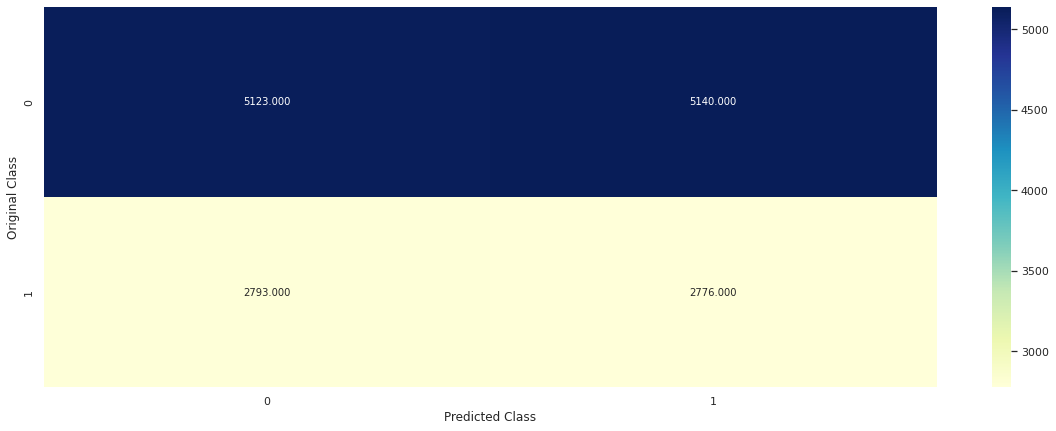

-------------------- Precision matrix (Columm Sum=1) --------------------


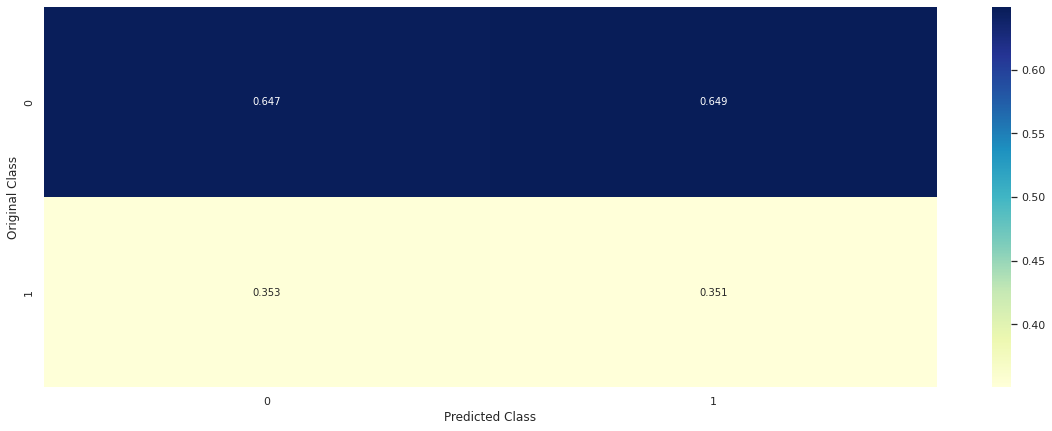

-------------------- Recall matrix (Row sum=1) --------------------


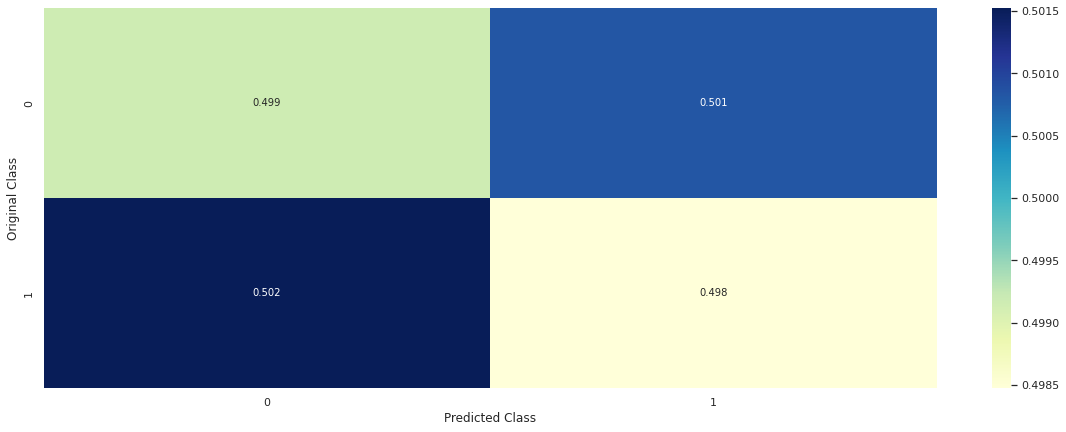

In [479]:
# We need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
test_data_len = X_test.shape[0]
cv_data_len = X_cv.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,2))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,2)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))


# Test-Set error.
# We create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,2))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,2)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

## Logistic Regression with class balancing


for alpha = 1e-06
Log Loss : 0.6416813442490548
for alpha = 1e-05
Log Loss : 0.6243857659266561
for alpha = 0.0001
Log Loss : 0.6117935899165226
for alpha = 0.001
Log Loss : 0.6104845359228169
for alpha = 0.01
Log Loss : 0.6094081993974643
for alpha = 0.1
Log Loss : 0.609961343284655
for alpha = 1
Log Loss : 0.6122377928706608
for alpha = 10
Log Loss : 0.6135637369456824
for alpha = 100
Log Loss : 0.6137594797943389
for alpha = 1000
Log Loss : 0.6137826913692297
for alpha = 10000
Log Loss : 0.613786484400627
for alpha = 100000
Log Loss : 0.6137876760054186


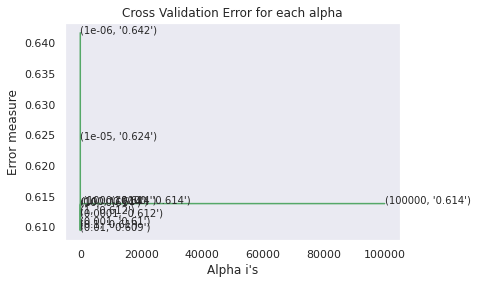

For values of best alpha =  0.01 The train log loss is: 0.6115516050746345
For values of best alpha =  0.01 The cross validation log loss is: 0.6094081993974643
For values of best alpha =  0.01 The test log loss is: 0.6076721280048767


In [480]:
alpha = [10 ** x for x in range(-6, 6)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train,y_train)
    sig_clf_probs = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train,y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The train log loss is:",
      log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The cross validation log loss is:",
      log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The test log loss is:",
      log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

CV Accuracy : 64.03474141334387
Test Accuracy : 64.35699848408288
Log loss : 0.6094081993974643
Number of mis-classified points : 0.33549151204105804

-------------------- Confusion matrix --------------------


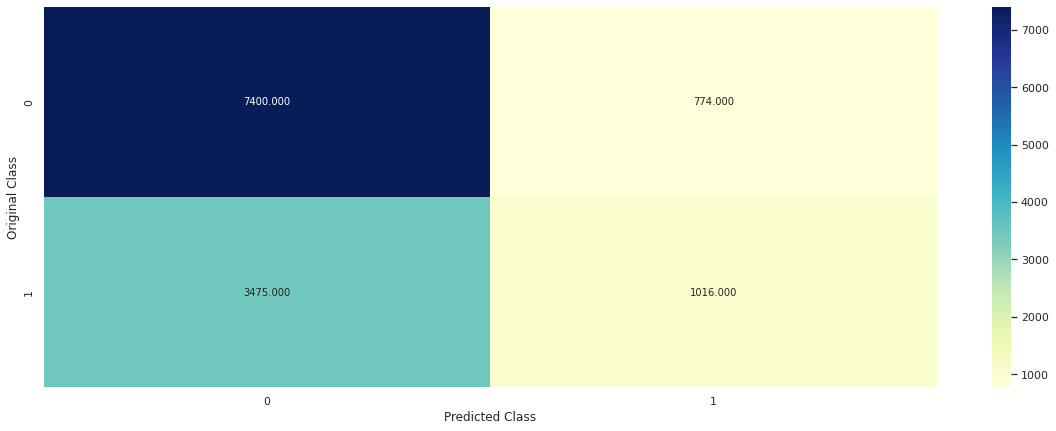

-------------------- Precision matrix (Columm Sum=1) --------------------


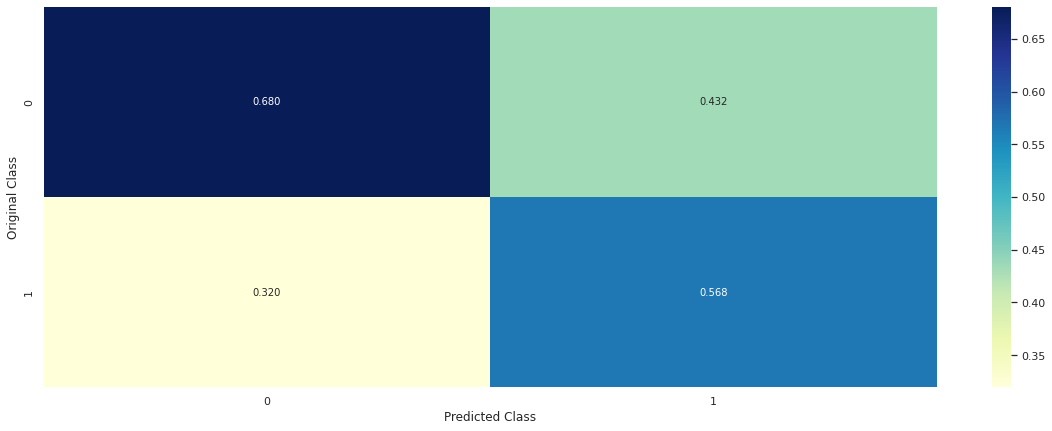

-------------------- Recall matrix (Row sum=1) --------------------


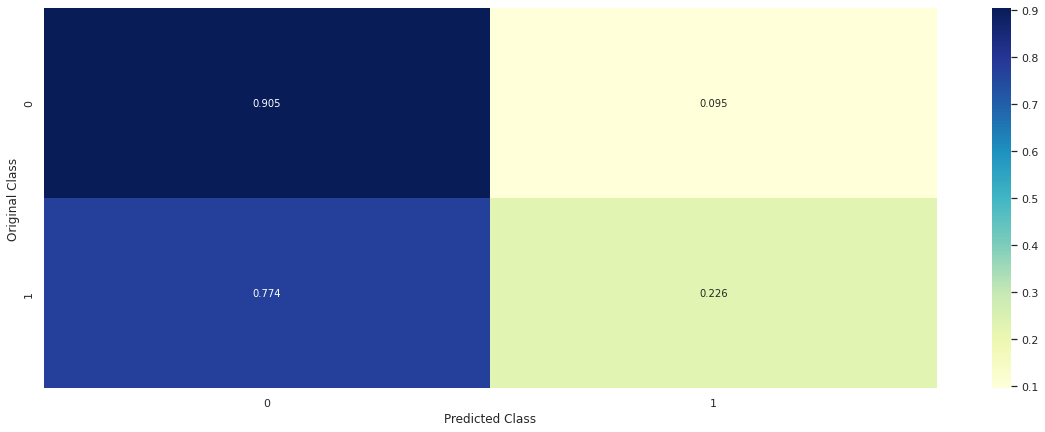

In [481]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(X_train, y_train, X_cv, y_cv, X_test,y_test,clf)

### Test some points out


- Correctly predicted

In [266]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train,y_train)
test_point_index = 1
no_feature = 1000
predicted_cls = sig_clf.predict(Xr[test_point_index].reshape(1, -1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(Xr[test_point_index].reshape(1, -1)),4))
print("Actual Class :", yr[test_point_index].reshape(1, -1))
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]

Predicted Class : 0
Predicted Class Probabilities: [[0.8689 0.1311]]
Actual Class : [[0]]


- Incorrectly predicted

In [267]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train,y_train)
test_point_index = 5456
no_feature = 1000
predicted_cls = sig_clf.predict(Xr[test_point_index].reshape(1, -1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(Xr[test_point_index].reshape(1, -1)),4))
print("Actual Class :", yr[test_point_index].reshape(1, -1))
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]

Predicted Class : 1
Predicted Class Probabilities: [[0.4411 0.5589]]
Actual Class : [[0]]


## Linear Support Vector Machines

for alpha = 1e-06
Log Loss : 0.6368244774345216
for alpha = 1e-05
Log Loss : 0.623689817607561
for alpha = 0.0001
Log Loss : 0.6145379733082906
for alpha = 0.001
Log Loss : 0.6130833702049235
for alpha = 0.01
Log Loss : 0.6121027062435168
for alpha = 0.1
Log Loss : 0.611991964352521
for alpha = 1
Log Loss : 0.6121975745962287
for alpha = 10
Log Loss : 0.6133472705937375
for alpha = 100
Log Loss : 0.6137885903041137
for alpha = 1000
Log Loss : 0.6137885676311207
for alpha = 10000
Log Loss : 0.6137887263874748
for alpha = 100000
Log Loss : 0.6137887264403914


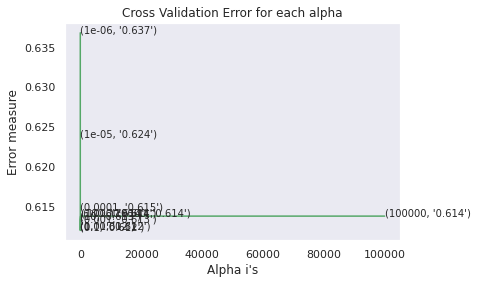

For values of best alpha =  0.1 The train log loss is: 0.6152994375496479
For values of best alpha =  0.1 The cross validation log loss is: 0.611991964352521
For values of best alpha =  0.1 The test log loss is: 0.6119633923630047


In [265]:
alpha = [10 ** x for x in range(-6, 6)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train,y_train)
    sig_clf_probs = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train,y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The train log loss is:",
      log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The cross validation log loss is:",
      log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The test log loss is:",
      log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

CV Accuracy : 64.54007106198183
Test Accuracy : 64.8244062657908
Log loss : 0.611991964352521
Number of mis-classified points : 0.3296486379786814

-------------------- Confusion matrix --------------------


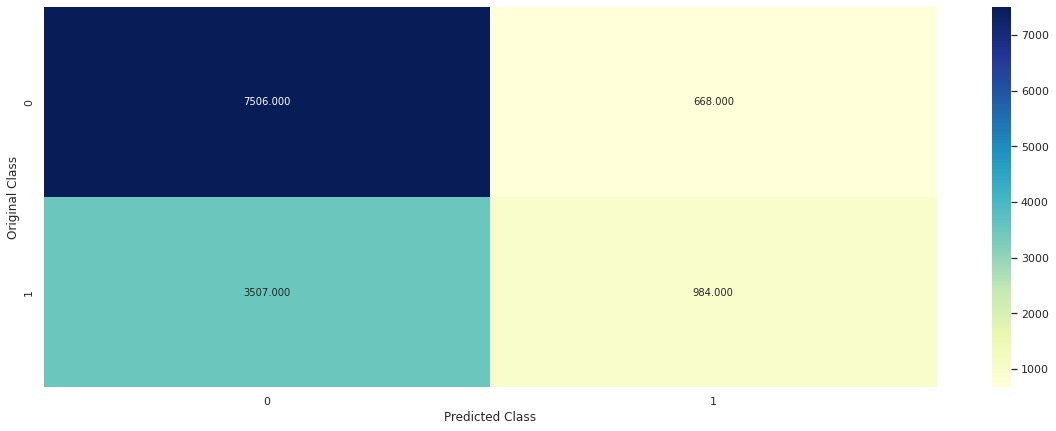

-------------------- Precision matrix (Columm Sum=1) --------------------


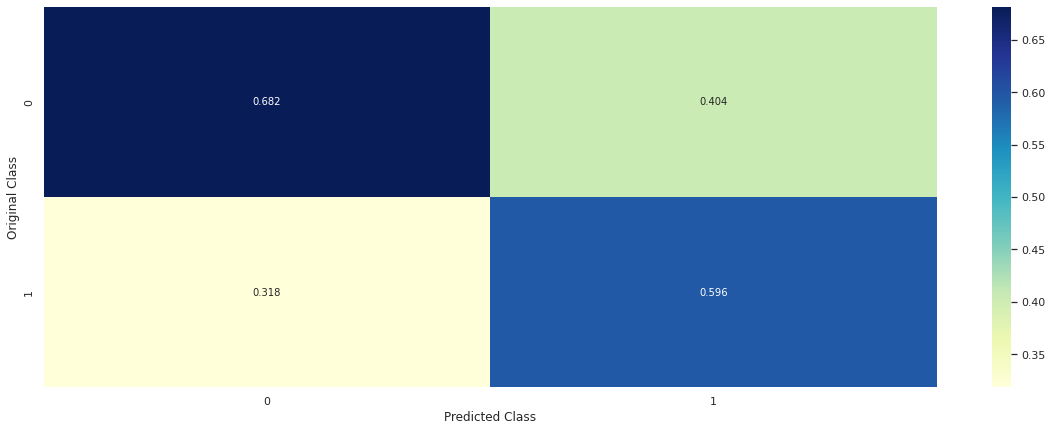

-------------------- Recall matrix (Row sum=1) --------------------


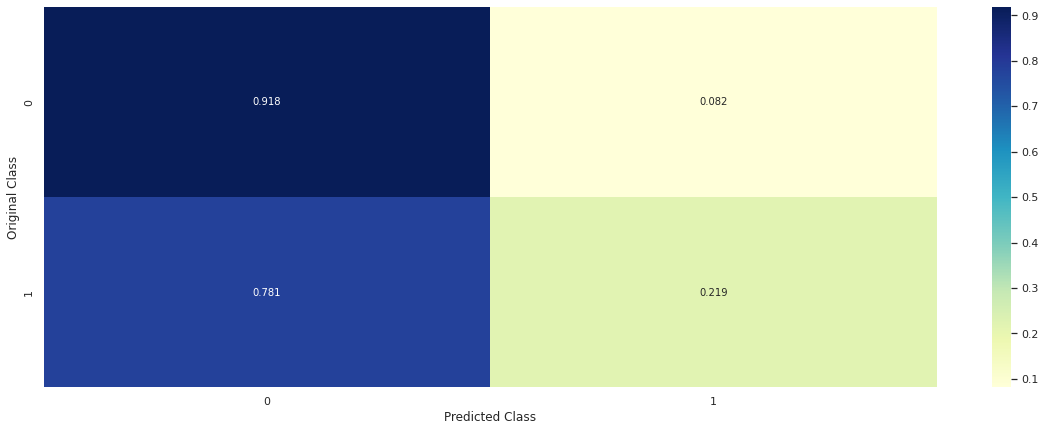

In [266]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
predict_and_plot_confusion_matrix(X_train, y_train, X_cv, y_cv, X_test, y_test,clf)

## Random Forest

In [504]:
alpha = [90, 100,300]
max_depth = [10,70]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='entropy', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(X_train, y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(X_train, y_train)
        sig_clf_probs = sig_clf.predict_proba(X_cv)
        cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 



best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='entropy', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best estimator = ', 
      alpha[int(best_alpha/2)], 
      "The train log loss is:",
      log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(X_cv)
print('For values of best estimator = ', 
      alpha[int(best_alpha/2)], 
      "The cross validation log loss is:",
      log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(X_test)
print('For values of best estimator = ', 
      alpha[int(best_alpha/2)], 
      "The test log loss is:",
      log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


for n_estimators = 90 and max depth =  10
Log Loss : 0.5700513274819496
for n_estimators = 90 and max depth =  70
Log Loss : 0.5631429342460026
for n_estimators = 100 and max depth =  10
Log Loss : 0.5700744993898993
for n_estimators = 100 and max depth =  70
Log Loss : 0.5630492643149989
for n_estimators = 300 and max depth =  10
Log Loss : 0.5697180805715685
for n_estimators = 300 and max depth =  70
Log Loss : 0.5622805485987004
For values of best estimator =  300 The train log loss is: 0.2022457016963939
For values of best estimator =  300 The cross validation log loss is: 0.5622805485987004
For values of best estimator =  300 The test log loss is: 0.558409528085301


CV Accuracy : 70.76983813659692
Test Accuracy : 70.80596260737747
Log loss : 0.5622805485987004
Number of mis-classified points : 0.29395973154362415

-------------------- Confusion matrix --------------------


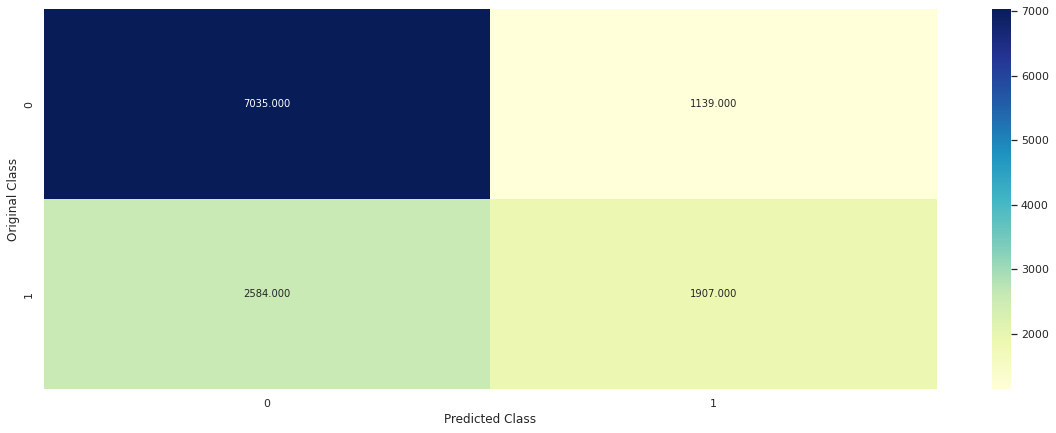

-------------------- Precision matrix (Columm Sum=1) --------------------


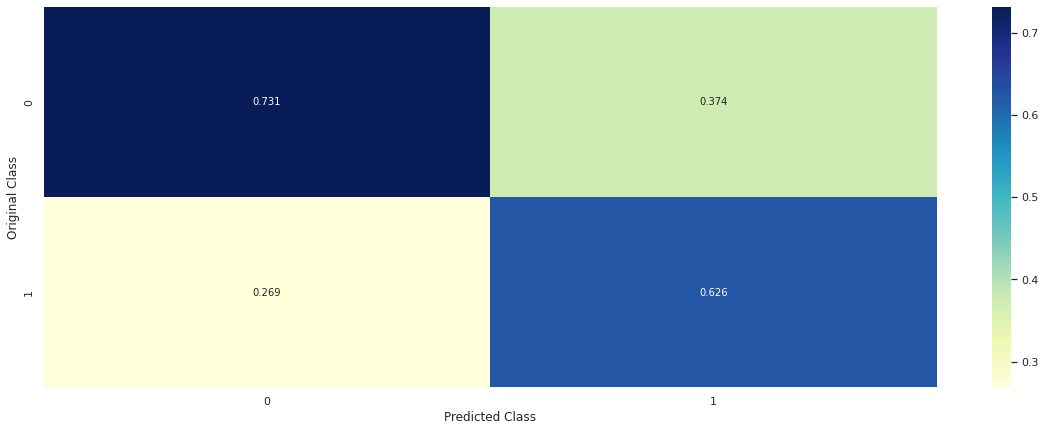

-------------------- Recall matrix (Row sum=1) --------------------


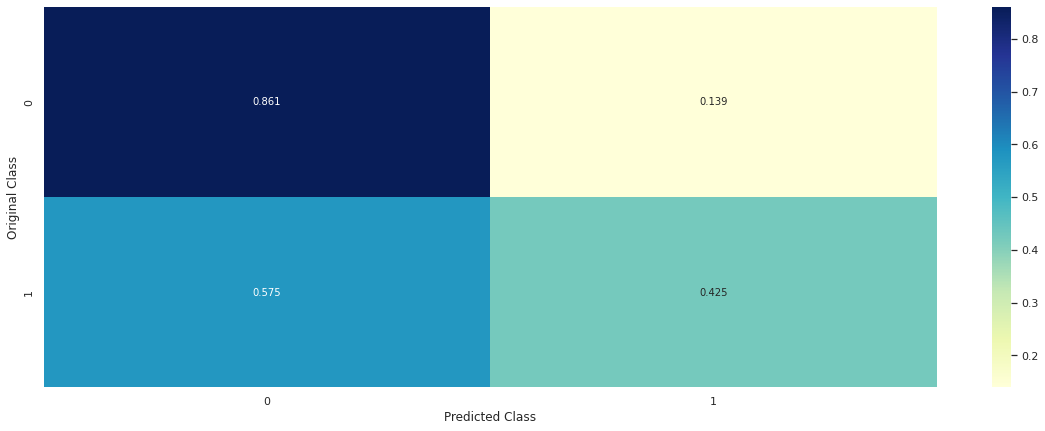

In [505]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='entropy', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(X_train, y_train,X_cv,y_cv,X_test,y_test, clf)

## Let's try UPSAMPLING

In [346]:
# define oversampling strategy
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
X_over, y_over = oversample.fit_resample(X, y)
print('Before Upsampling',X.shape, ' ', y.shape)
print('After Upsampling',X_over.shape, ' ', y_over.shape)

Before Upsampling (79156, 29)   (79156,)
After Upsampling (102010, 29)   (102010,)


In [347]:
y.value_counts()

0    51005
1    28151
Name: diabetes_mellitus, dtype: int64

In [348]:
y_over.value_counts()

1    51005
0    51005
Name: diabetes_mellitus, dtype: int64

In [349]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.25, random_state=42)
X_train,X_cv,y_train,y_cv = train_test_split(X_train,y_train,test_size = 0.25,random_state = 42)

In [350]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
X_train['gender'] = le.fit_transform(X_train.gender.values)
X_cv['gender'] = le.transform(X_cv.gender.values)
X_test['gender'] = le.transform(X_test.gender.values)

In [351]:
X_train['ethnicity'] = le.fit_transform(X_train.ethnicity.values)
X_cv['ethnicity'] = le.transform(X_cv.ethnicity.values)
X_test['ethnicity'] = le.transform(X_test.ethnicity.values)

In [352]:
X_train['icu_type'] = le.fit_transform(X_train.icu_type.values)
X_cv['icu_type'] = le.transform(X_cv.icu_type.values)
X_test['icu_type'] = le.transform(X_test.icu_type.values)

In [353]:
#Use standardscaler to standardize the features

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_cv  = sc.transform(X_cv)
X_test  = sc.transform(X_test)

## Logistic Regression

for alpha = 1e-06
Log Loss : 0.6748122520170581
for alpha = 1e-05
Log Loss : 0.6526596170281397
for alpha = 0.0001
Log Loss : 0.6396407448497936
for alpha = 0.001
Log Loss : 0.6376976816402229
for alpha = 0.01
Log Loss : 0.6373755510249139
for alpha = 0.1
Log Loss : 0.6377206028294264
for alpha = 1
Log Loss : 0.6430551113413915
for alpha = 10
Log Loss : 0.6494465367095666
for alpha = 100
Log Loss : 0.6508238867862473
for alpha = 1000
Log Loss : 0.6509773607600136
for alpha = 10000
Log Loss : 0.6509924264504654
for alpha = 100000
Log Loss : 0.6509936355285368


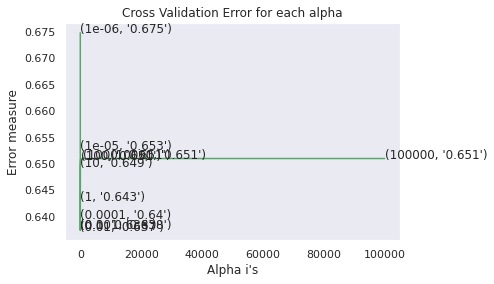

For values of best alpha =  0.01 The train log loss is: 0.630867440911819
For values of best alpha =  0.01 The cross validation log loss is: 0.6373755510249139
For values of best alpha =  0.01 The test log loss is: 0.6334655335187429


In [354]:
alpha = [10 ** x for x in range(-6, 6)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train,y_train)
    sig_clf_probs = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train,y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The train log loss is:",
      log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The cross validation log loss is:",
      log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The test log loss is:",
      log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

CV Accuracy : 63.43911747791081
Test Accuracy : 64.04736697643415
Log loss : 0.6373755510249139
Number of mis-classified points : 0.36587023579233546

-------------------- Confusion matrix --------------------


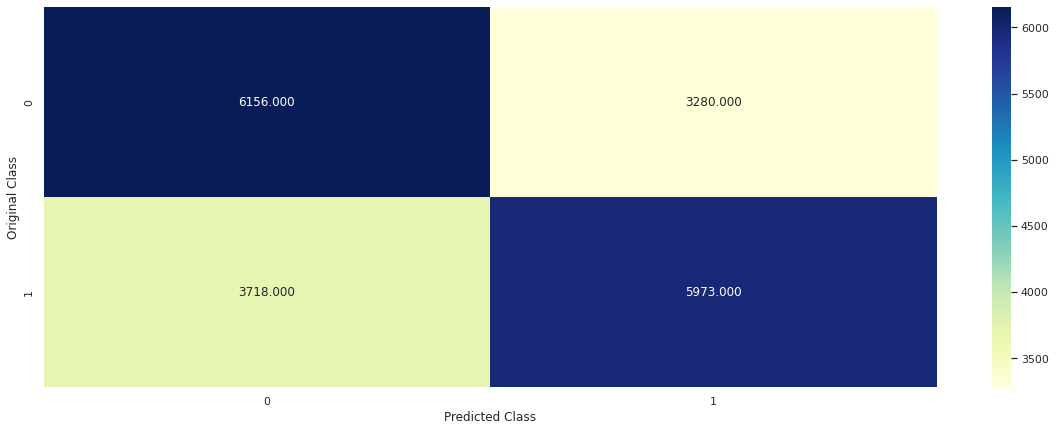

-------------------- Precision matrix (Columm Sum=1) --------------------


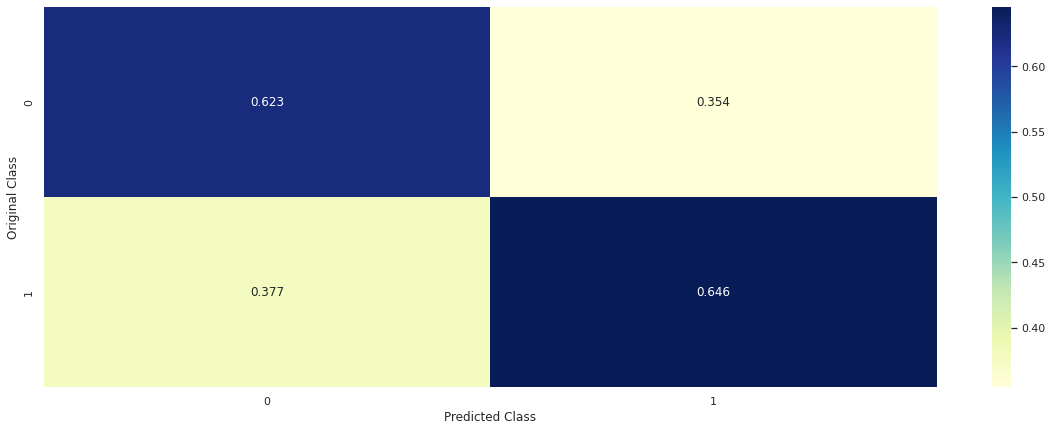

-------------------- Recall matrix (Row sum=1) --------------------


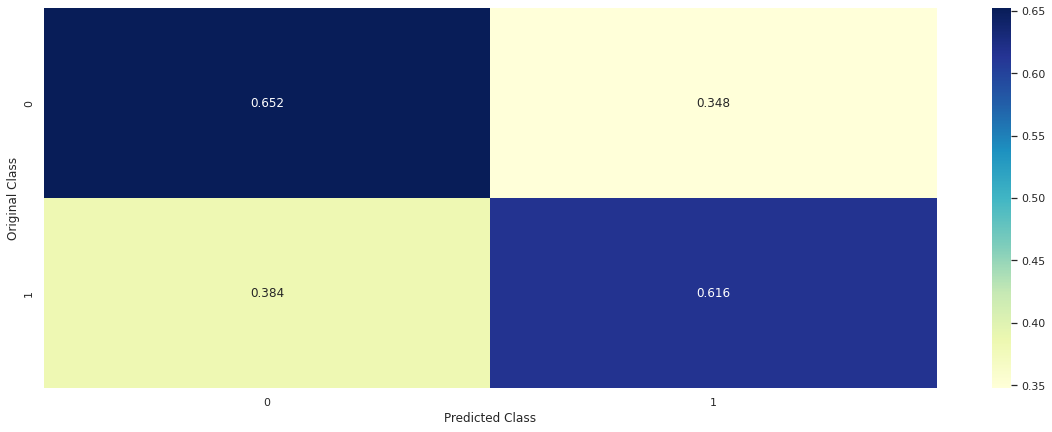

In [355]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(X_train, y_train, X_cv, y_cv,X_test, y_test, clf)

## Random Forest

In [356]:
alpha = [100,300,500]
max_depth = [3, 5]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(X_train, y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(X_train, y_train)
        sig_clf_probs = sig_clf.predict_proba(X_cv)
        cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 



best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best estimator = ', 
      alpha[int(best_alpha/2)], 
      "The train log loss is:",
      log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(X_cv)
print('For values of best estimator = ', 
      alpha[int(best_alpha/2)], 
      "The cross validation log loss is:",
      log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(X_test)
print('For values of best estimator = ', 
      alpha[int(best_alpha/2)], 
      "The test log loss is:",
      log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


for n_estimators = 100 and max depth =  3
Log Loss : 0.6125423295238458
for n_estimators = 100 and max depth =  5
Log Loss : 0.5956533972711483
for n_estimators = 300 and max depth =  3
Log Loss : 0.612787916987225
for n_estimators = 300 and max depth =  5
Log Loss : 0.5970321209382472
for n_estimators = 500 and max depth =  3
Log Loss : 0.6130579834522982
for n_estimators = 500 and max depth =  5
Log Loss : 0.5969812894106366
For values of best estimator =  100 The train log loss is: 0.583502990242186
For values of best estimator =  100 The cross validation log loss is: 0.5956533972711483
For values of best estimator =  100 The test log loss is: 0.5916780752527203


CV Accuracy : 68.33272337533329
Test Accuracy : 68.63506254166177
Log loss : 0.5956533972711483
Number of mis-classified points : 0.31452919956083025

-------------------- Confusion matrix --------------------


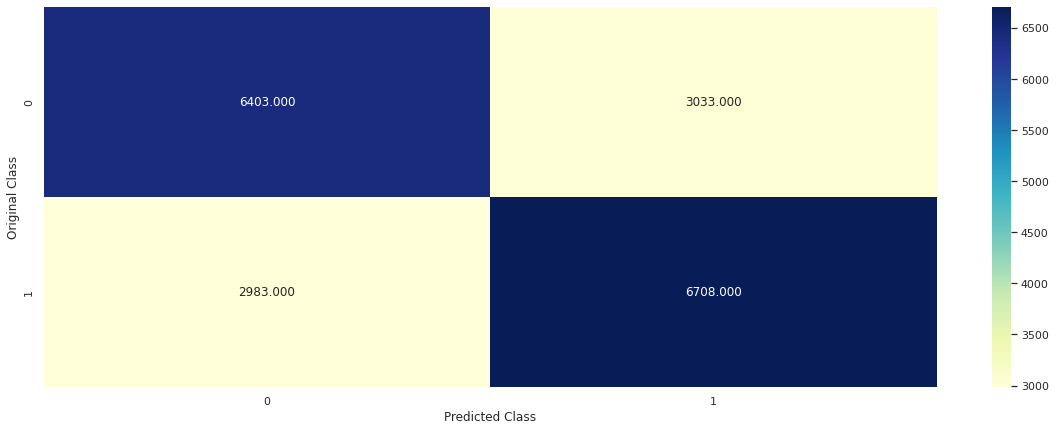

-------------------- Precision matrix (Columm Sum=1) --------------------


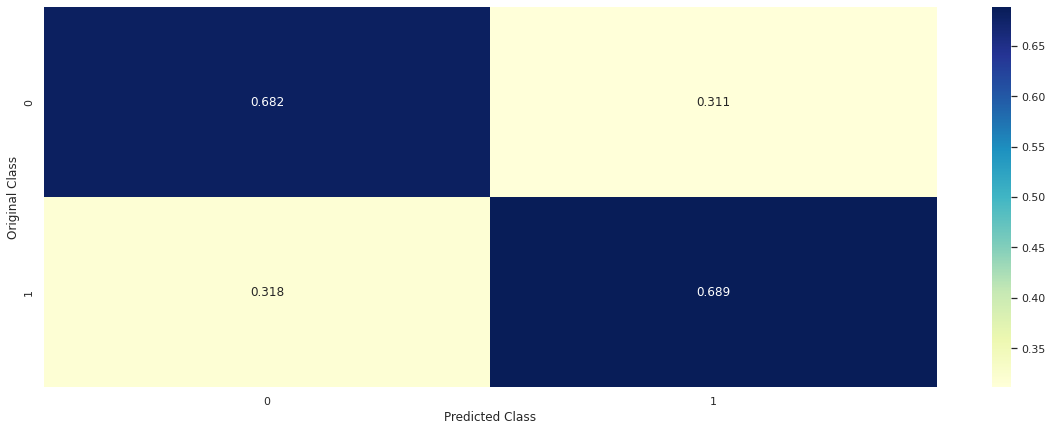

-------------------- Recall matrix (Row sum=1) --------------------


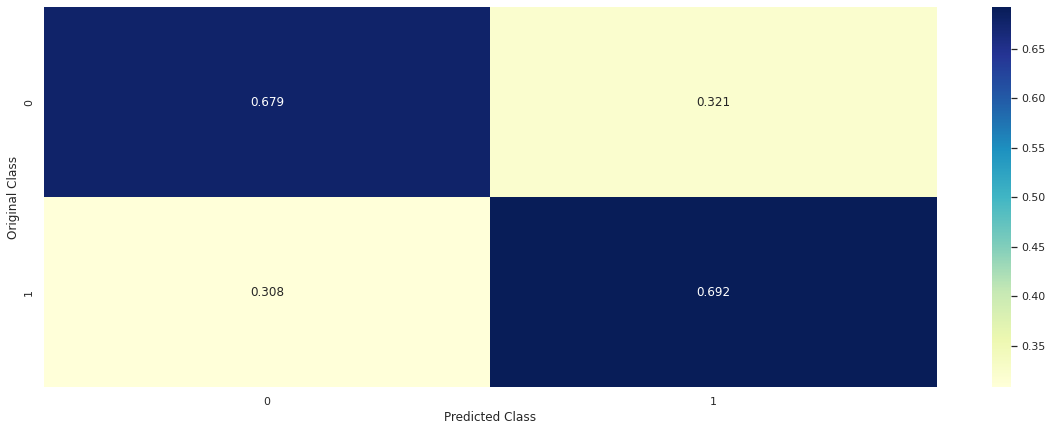

In [357]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(X_train, y_train,X_cv,y_cv, X_test, y_test,clf)

## Trying Feature Selection

In [482]:
X = data
X = X.drop(["diabetes_mellitus"], axis = 1)

y = data['diabetes_mellitus']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train,X_cv,y_train,y_cv = train_test_split(X_train,y_train,test_size = 0.20,random_state = 42)

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
X_train['gender'] = le.fit_transform(X_train.gender.values)
X_cv['gender'] = le.transform(X_cv.gender.values)
X_test['gender'] = le.transform(X_test.gender.values)

X_train['ethnicity'] = le.fit_transform(X_train.ethnicity.values)
X_cv['ethnicity'] = le.transform(X_cv.ethnicity.values)
X_test['ethnicity'] = le.transform(X_test.ethnicity.values)

X_train['icu_type'] = le.fit_transform(X_train.icu_type.values)
X_cv['icu_type'] = le.transform(X_cv.icu_type.values)
X_test['icu_type'] = le.transform(X_test.icu_type.values)

In [483]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_cv_sc  = sc.transform(X_cv)
X_test_sc  = sc.transform(X_test)

X_train = pd.DataFrame(X_train_sc, index=X_train.index, columns=X_train.columns)
X_cv = pd.DataFrame(X_cv_sc, index=X_cv.index, columns=X_cv.columns)
X_test = pd.DataFrame(X_test_sc, index=X_test.index, columns=X_test.columns)

y_train = pd.DataFrame(y_train,columns = ['diabetes_mellitus'])
y_cv = pd.DataFrame(y_cv,columns = ['diabetes_mellitus'])
y_test = pd.DataFrame(y_test,columns = ['diabetes_mellitus'])

def feature_selection(X_train,y_train,X_cv,y_cv,X_test,y_test,target,top_features_to_pick=.10,subclass='ignore'):
    # to run on multiclass classification , set the subclass argument to 'multi'
    print('Initiating feature selection...')

    from sklearn.ensemble import RandomForestClassifier as rfc
    top_features_to_pick =1-top_features_to_pick
    # Random Forest
    max_fe = min(70, int(np.sqrt(len(X_train.columns))))
    max_sa = min(1000, int(np.sqrt(len(X_train))))
    m = rfc(100,max_depth=5,max_features=max_fe,n_jobs=-1,max_samples=max_sa,random_state=42)
    
    m.fit(X_train,y_train)
    fe_imp_table= pd.DataFrame(m.feature_importances_,columns=['Importance'],index=X_train.columns)
    print(fe_imp_table)
    fe_imp_table = fe_imp_table[fe_imp_table['Importance']>= fe_imp_table.quantile(top_features_to_pick)[0]]
    print(fe_imp_table)
    top = fe_imp_table.index
    dummy_all_columns_RF= X_train[top].columns
    print(dummy_all_columns_RF)

    X_train1 = pd.concat([X_train, y_train], axis=1)

    # Import label encoder
    from sklearn import preprocessing

    # label_encoder object knows how to understand word labels.
    label_encoder = preprocessing.LabelEncoder()

    # Encode labels in column 'species'.
    X_train1.drop(target,axis=1,inplace=True)
    s = label_encoder.fit_transform(y_train[target])
    #print(pd.Series(s))
    X_train1[target]= pd.Series(s)


    # we can now select top correlated feature
    if subclass != 'multi':
        corr = pd.DataFrame(np.corrcoef(X_train1.T))
        corr.columns = X_train1.columns
        corr.index = X_train1.columns
        # corr = corr[self.target].abs().sort_values(ascending=False)[0:self.top_features_to_pick+1]
        corr = corr[target].abs()
        corr = corr[corr.index!=target] # drop the target column
        corr = corr[corr >= corr.quantile(top_features_to_pick)]
        corr = pd.DataFrame(dict(features=corr.index,value=corr)).reset_index(drop=True)
        corr = corr.drop_duplicates(subset='value')
        corr = corr['features']
        # corr = pd.DataFrame(dict(features=corr.index,value=corr)).reset_index(drop=True)
        # corr = corr.drop_duplicates(subset='value')[0:self.top_features_to_pick+1]
        # corr = corr['features']
    else:
        corr = list()
    selected_columns = list(set(list(dummy_all_columns_RF) + list(corr)))
    print(selected_columns)

    # X_train = X_train[selected_columns]
    # X_test = X_test[selected_columns]

    return selected_columns

selected_columns = feature_selection(X_train,y_train,X_cv,y_cv,X_test,y_test,'diabetes_mellitus',top_features_to_pick=.10,subclass='ignore')
X_train = X_train[selected_columns]
X_cv = X_cv[selected_columns]
X_test = X_test[selected_columns]

X_train = np.array(X_train)
X_cv = np.array(X_cv)
X_test = np.array(X_test)

y_train = y_train.iloc[:,0]
y_cv = y_cv.iloc[:,0]
y_test = y_test.iloc[:,0]

Initiating feature selection...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


                   Importance
gender               0.002491
ethnicity            0.018843
age                  0.053580
height               0.031725
weight               0.078219
bmi                  0.083101
icu_type             0.024434
h1_temp_max          0.031262
d1_albumin_max       0.026993
d1_bilirubin_max     0.029378
d1_bun_max           0.083263
d1_glucose_min       0.127573
d1_hco3_max          0.026987
d1_platelets_max     0.044685
d1_potassium_max     0.051381
d1_sodium_max        0.026780
d1_wbc_max           0.038619
d1_heartrate_max     0.043191
heart_rate_apache    0.046375
gcs_motor_apache     0.010585
gcs_eyes_apache      0.006021
creatinine_apache    0.054835
h1_spo2_max          0.016350
map_apache           0.040082
ventilated_apache    0.003247
                Importance
bmi               0.083101
d1_bun_max        0.083263
d1_glucose_min    0.127573
Index(['bmi', 'd1_bun_max', 'd1_glucose_min'], dtype='object')
['d1_bun_max', 'd1_glucose_min', 'bmi']


## Random Forest

In [494]:
alpha = [90, 100,300]
max_depth = [10,70]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='entropy', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(X_train, y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(X_train, y_train)
        sig_clf_probs = sig_clf.predict_proba(X_cv)
        cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 



best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best estimator = ', 
      alpha[int(best_alpha/2)], 
      "The train log loss is:",
      log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(X_cv)
print('For values of best estimator = ', 
      alpha[int(best_alpha/2)], 
      "The cross validation log loss is:",
      log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(X_test)
print('For values of best estimator = ', 
      alpha[int(best_alpha/2)], 
      "The test log loss is:",
      log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


for n_estimators = 90 and max depth =  10
Log Loss : 0.5904103111891289
for n_estimators = 90 and max depth =  70
Log Loss : 0.6149571867152172
for n_estimators = 100 and max depth =  10
Log Loss : 0.5903477354697368
for n_estimators = 100 and max depth =  70
Log Loss : 0.614834020414343
for n_estimators = 300 and max depth =  10
Log Loss : 0.5903042859230102
for n_estimators = 300 and max depth =  70
Log Loss : 0.6141742711237183
For values of best estimator =  300 The train log loss is: 0.5567883672841573
For values of best estimator =  300 The cross validation log loss is: 0.590653277553476
For values of best estimator =  300 The test log loss is: 0.5873285834638876


CV Accuracy : 68.5748124753257
Test Accuracy : 68.79737241030823
Log loss : 0.5903042859230103
Number of mis-classified points : 0.31385708645874455

-------------------- Confusion matrix --------------------


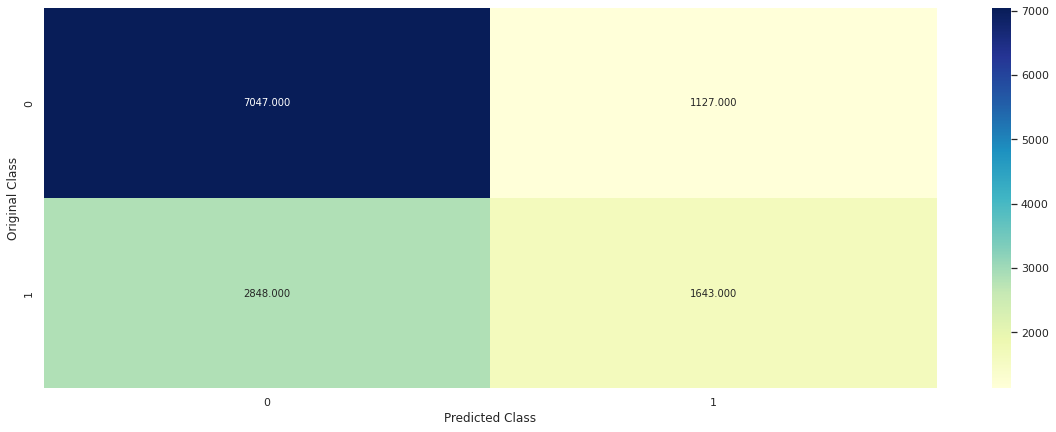

-------------------- Precision matrix (Columm Sum=1) --------------------


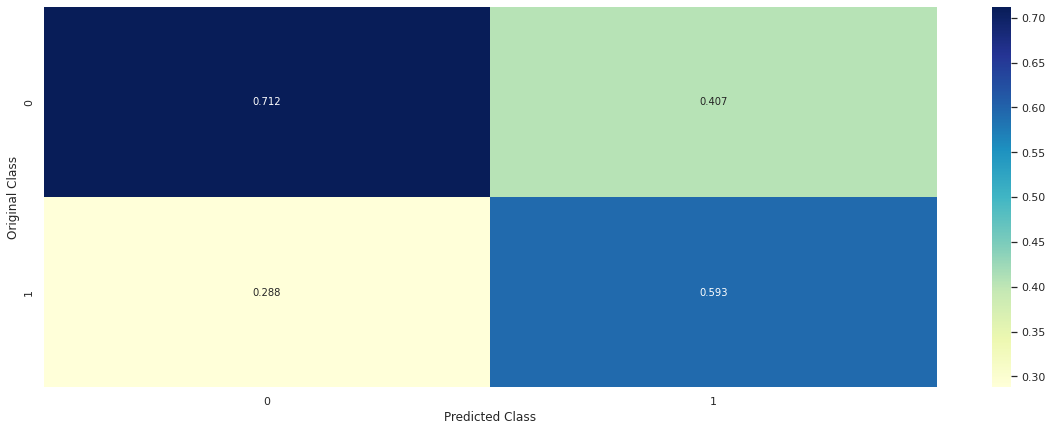

-------------------- Recall matrix (Row sum=1) --------------------


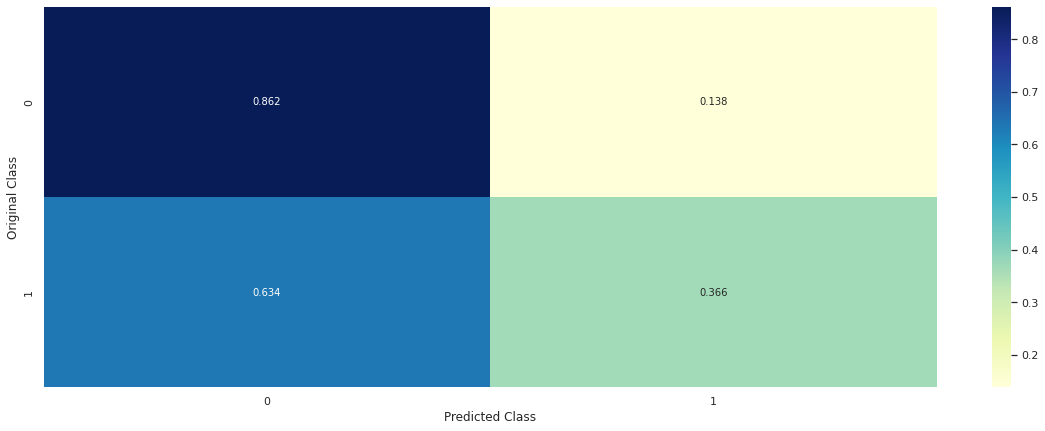

In [495]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='entropy', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(X_train, y_train,X_cv,y_cv, X_test, y_test,clf)

## Summarizing using Pretty table
- So, upsampling didnt help in this case

In [359]:
from prettytable import PrettyTable

ptable = PrettyTable()
ptable.title = "*** Model Summary *** [Performance Metric: Log-Loss]"
ptable.field_names=["Model Name","Train LogLoss","CV LogLoss","Test LogLoss","CV Accuracy","Test Accuracy"]
ptable.add_row(["Logistic Regression With Class balancing","0.596","0.599","0.593","64.27","64.23"])
ptable.add_row(["Linear SVM","0.600","0.602","0.597","67.05","67.79"])
ptable.add_row(["Random Forest Classifier ","0.553","0.558","0.558","69.00","69.21"])
ptable.add_row(["Logistic Regression With Class balancing(UPSAMPLING) ","0.631","0.636","0.634","63.78","64.04"])
ptable.add_row(["Random Forest Classifier With Class balancing(UPSAMPLING)","0.583","0.593","0.591","68.33","68.63"])


print(ptable)

+-------------------------------------------------------------------------------------------------------------------------------------+
|                                         *** Model Summary *** [Performance Metric: Log-Loss]                                        |
+-----------------------------------------------------------+---------------+------------+--------------+-------------+---------------+
|                         Model Name                        | Train LogLoss | CV LogLoss | Test LogLoss | CV Accuracy | Test Accuracy |
+-----------------------------------------------------------+---------------+------------+--------------+-------------+---------------+
|          Logistic Regression With Class balancing         |     0.596     |   0.599    |    0.593     |    64.27    |     64.23     |
|                         Linear SVM                        |     0.600     |   0.602    |    0.597     |    67.05    |     67.79     |
|                 Random Forest Classifier      

## Summary :-
- Above we can see that there is inflection at K = 5 . Before  loss was decreasing faster as compared to the loss decreasing after it . So , the best value of K is 5.

# TSNE

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 50659 samples in 0.001s...
[t-SNE] Computed neighbors for 50659 samples in 55.436s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50659
[t-SNE] Computed conditional probabilities for sample 2000 / 50659
[t-SNE] Computed conditional probabilities for sample 3000 / 50659
[t-SNE] Computed conditional probabilities for sample 4000 / 50659
[t-SNE] Computed conditional probabilities for sample 5000 / 50659
[t-SNE] Computed conditional probabilities for sample 6000 / 50659
[t-SNE] Computed conditional probabilities for sample 7000 / 50659
[t-SNE] Computed conditional probabilities for sample 8000 / 50659
[t-SNE] Computed conditional probabilities for sample 9000 / 50659
[t-SNE] Computed conditional probabilities for sample 10000 / 50659
[t-SNE] Computed conditional probabilities for sample 11000 / 50659
[t-SNE] Computed conditional probabilities for sample 12000 / 50659
[t-SNE] Computed conditional probabilities for s

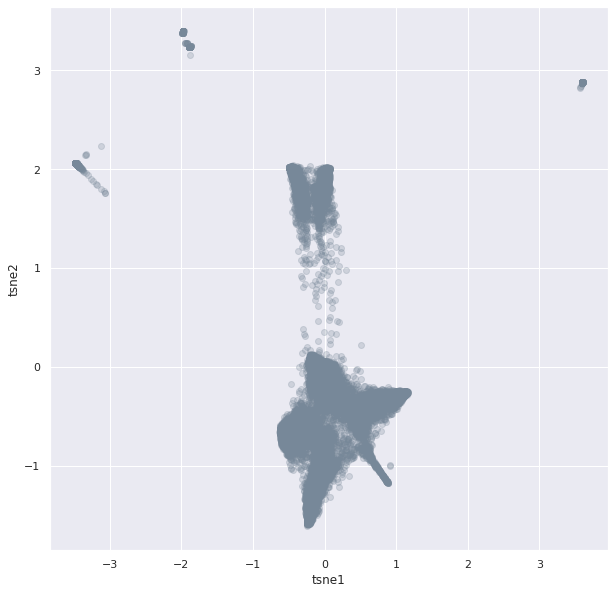

In [517]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=80, n_iter=250, learning_rate=200)
tsne_scale_results = tsne.fit_transform(X_train)
tsne_df_scale = pd.DataFrame(tsne_scale_results, columns=['tsne1', 'tsne2'])
plt.figure(figsize = (10,10))
plt.scatter(tsne_df_scale.iloc[:,0],tsne_df_scale.iloc[:,1],alpha=0.25, facecolor='lightslategray')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.show()

Text(0, 0.5, 'Inertia')

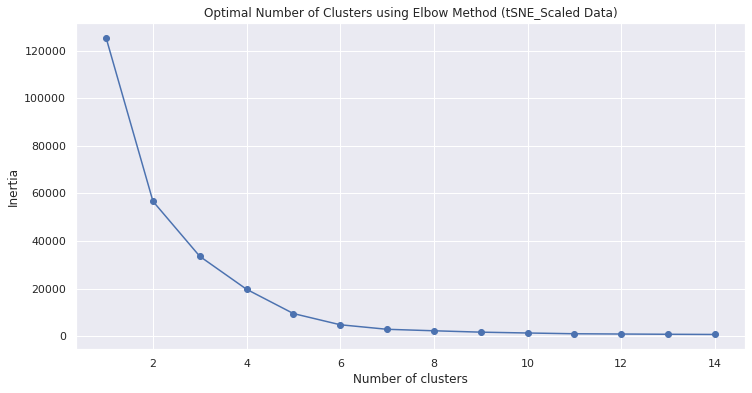

In [520]:
sse = []
k_list = range(1, 15)
for k in k_list:
    km = KMeans(n_clusters=k)
    km.fit(tsne_df_scale)
    sse.append([k, km.inertia_])
    
tsne_results_scale = pd.DataFrame({'Cluster': range(1,15), 'SSE': sse})
plt.figure(figsize=(12,6))
plt.plot(pd.DataFrame(sse)[0], pd.DataFrame(sse)[1], marker='o')
plt.title('Optimal Number of Clusters using Elbow Method (tSNE_Scaled Data)')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [522]:
kmeans_tsne_scale = KMeans(n_clusters=2, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df_scale)
labels_tsne_scale = kmeans_tsne_scale.labels_
clusters_tsne_scale = pd.concat([tsne_df_scale, pd.DataFrame({'tsne_clusters':labels_tsne_scale})], axis=1)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


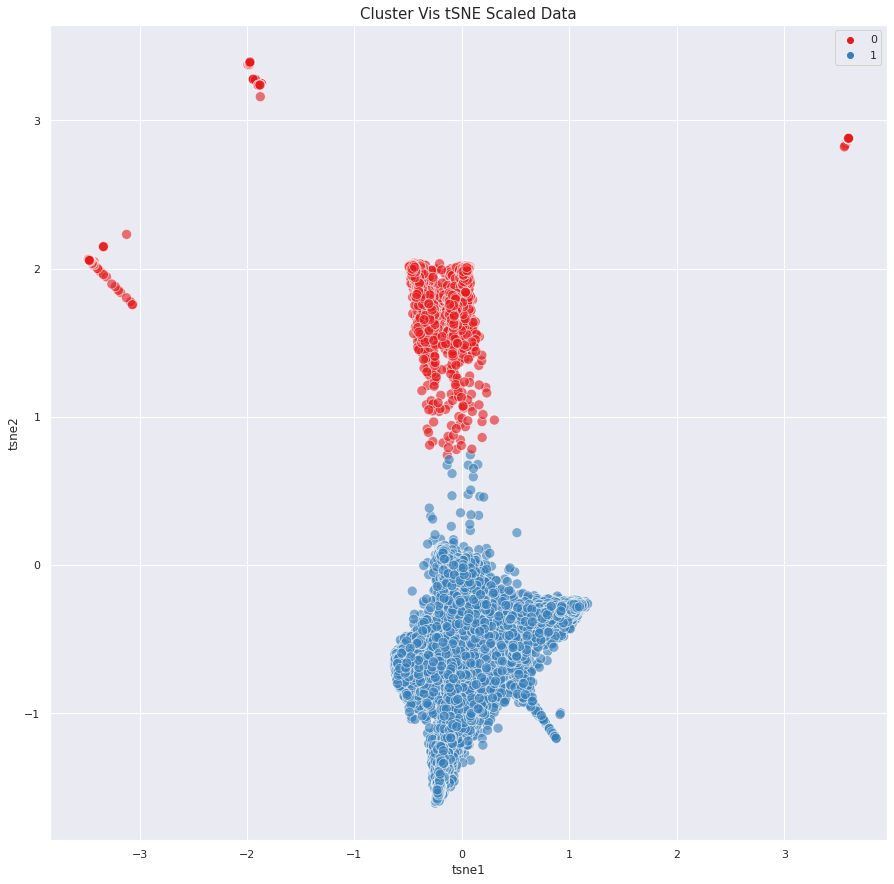

In [523]:
plt.figure(figsize = (15,15))
sns.scatterplot(clusters_tsne_scale.iloc[:,0],clusters_tsne_scale.iloc[:,1],hue=labels_tsne_scale, palette='Set1', s=100, alpha=0.6).set_title('Cluster Vis tSNE Scaled Data', fontsize=15)
plt.legend()
plt.show()